[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maulanaisa/plate-detector/blob/main/Masters.ipynb)
Instal KERAS-OCR package dan mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install keras-ocr

Mounted at /content/drive
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 9.5MB 19.7MB/s 
     |████████████████████████████████| 860kB 51.3MB/s 
     |████████████████████████████████| 133kB 40.2MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.6-cp37-none-any.whl size=42937 sha256=02743a18cc69f0be09c7be1e03ffee839ecadccdf075cce45a7d3fb972b19125
  Stored in directory: /root/.cache/pip/wheels/79/59/e6/79dd15333b911d51ea68d7e4c325e14f042eacc141201dca44
Successfully built keras-ocr


Import library yang dibutuhkan

In [2]:
#Import packages
import cv2
import imutils as im
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import keras_ocr
import os
import math

Inisialisasi folder dan weight

In [3]:
# Folder gambar untuk gambar input dan folder untuk menyimpan hasil
uploads_dir = "/content/drive/MyDrive/KP/test_case_normal"
uploads_dir_2 = "/content/drive/MyDrive/KP/test_case_soft_skewed"
uploads_dir_3 = "/content/drive/MyDrive/KP/test_case_hard_skewed"
save_dir = "/content/drive/MyDrive/KP/Result Images for Edge Detection, Skew Correction and OCR"

# # Untuk membaca file satu per satu
# input = "/content/drive/MyDrive/KP/Test Images for Edge Detection, Skew Correction and OCR/7.jpg"
# image = cv2.imread(input)

# Input weight Keras-OCR hasil traning
recognizer = keras_ocr.recognition.Recognizer()
recognizer.model.load_weights('/content/drive/MyDrive/KP/OCR/plat1.h5')
pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer)


Looking for /root/.keras-ocr/crnn_kurapan.h5
Looking for /root/.keras-ocr/craft_mlt_25k.h5


Fungsi-fungsi yang akan digunakan

In [4]:
# Fungsi untuk mengurutkan 4 edges pada plat agar konsisten
def order_points(pts):

  # Koordinat akan di urutkan dengan urutan kiri-atas
	# kanan-atas, kanan-bawah dan kiri-bawah
  rect = np.zeros((4, 2),dtype="float32")

  # Titik kiri-atas akan memiliki jumlah terkecil
  # dan titik kanan-bawah memiliki jumlah terbesar
  s = pts.sum(axis = 1)
  rect[0] = pts[np.argmin(s)]
  rect[2] = pts[np.argmax(s)]

  # Titik kanan-atas akan memiliki hasil pengurangan terkecil
  # dan titik kiri-bawah memiliki hasil pengurangan terbesar
  diff = np.diff(pts, axis = 1)
  rect[1] = pts[np.argmin(diff)]
  rect[3] = pts[np.argmax(diff)]

	# return koordinat yang sudah diurutkan
  return rect

# Fungsi untuk trasformasi gambar dengan mengambil gambar didalam area 4 titik
def four_point_transform(image, pts):
	
	(tl, tr, br, bl) = pts
	
  # Menghitung lebar gambar maksimum
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
 
	# Menghitung tinggi gambar maksimum
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
 
  # Transformasi gambar dengan mengambil 4 titik untuk medapatkan 
  # tampak atas dari area gamber yang diingin
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
 
	# Menghitung Matriks Transformasi
	M = cv2.getPerspectiveTransform(pts, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
	# Return gambar yang sudah di transformasi
	return warped

# Fungsi untuk menghitung sudut maksimal garis horizontal dari
# Edges plat yang terdeteksi
def count_angle(points) :
  atas_kiri, atas_kanan, bawah_kanan, bawah_kiri = points

  # Menghitung lebar dan tinggi di sepasang sisi
  height_1 = (atas_kanan[1]-atas_kiri[1])
  width_1 = (atas_kanan[0]-atas_kiri[0])
  height_2 = (bawah_kanan[1]-bawah_kiri[1])
  width_2 = (bawah_kanan[0]-bawah_kiri[0])

  # Mencari sudut maksimum relatif terhadap garis horizontal
  # Sudut positif arah jarum jam dari sumbu x positif
  degree_1 = math.atan2(height_1,width_1)
  degree_2 = math.atan2(height_2,width_2)
  if degree_1>=0 and degree_2>=0 :
    degree = max(degree_1,degree_2)
  elif degree_1<0 and degree_2>=0 :
    degree = degree_1
  elif degree_1>=0 and degree_2<0 :
    degree = degree_2
  elif degree_1<0 and degree_2<0 :
    degree = -1*(max(abs(degree_1),abs(degree_2)))
  else :
    degree = 0

  # mengubah dari unit radian ke derajat
  pi = math.pi
  degree_in_degree = (degree/(2*pi)*360)
  
  #return sudut dalam satuan derajat
  return degree_in_degree

# Fungsi untuk lokalisasi kandidat plat kendaraan
# input berupa gambar grayscale yang sudah di inverse (karena plat indonesia
# memiliki karakter cerah dengan latar gelap, algoritma ini awalnya dibuat untuk 
# karakter gelap pada latar cerah
def locate_license_plate_candidates(gray, keep=3):

  # Melakukan blackhat morphological operation untuk menonjolkan area gelap
  # pada latar cerah
  rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
  blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)

  # Mencari area terang pada gambar dengan close morphological operation
  squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
  # light = cv2.cvtColor(light, cv2.COLOR_BGR2GRAY)
  light = cv2.threshold(light, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
  # Mempertajam fitur gradient edges dengan metode scharr pada sumbu x
  # Kemudian mengembalikan range nilai piksel ke [0,255]
  gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,
  dx=1, dy=0, ksize=-1)
  gradX = np.absolute(gradX)
  (minVal, maxVal) = (np.min(gradX), np.max(gradX))
  gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
  gradX = gradX.astype("uint8")
  
  # Melakukan blur gauss pada gambar kemudian melakukan  closing morphological
  # operation dan kemudian melakukan tresholding dengan metode otsu
  gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
  gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
  # gradX = cv2.cvtColor(gradX, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gradX, 0, 255,
		cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  
  # Melakukan operasi erode dan dilate untuk membuang noise diluar objek signifikan
  thresh = cv2.erode(thresh, None, iterations=3)
  thresh = cv2.dilate(thresh, None, iterations=3)

  # Melakukan masking dengan gambar light hasil fungsi sebelumnya untuk
  # Memfokuskan gambar pada bagian cerah (tempat plat berada)
  # Kemudian melakukan operasi dilate dan erode untuk membuang noise dalam
  # objek signifikan
  thresh = cv2.bitwise_and(thresh, thresh, mask=light)
  thresh = cv2.dilate(thresh, None, iterations=5)
  thresh = cv2.erode(thresh, None, iterations=5)
  
  # Mencari kontur tertutup dari gambar
  cnts,hir = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts=sorted(cnts, key = cv2.contourArea, reverse = True)

  #Template untuk masking
  mask = np.ones(image.shape[:2], dtype="uint8") * 255
  
  # print(len(cnts))
  if len(cnts) >= 4 :
    cv2.drawContours(mask, cnts[4:], -1, 0, -1)
  thresh = cv2.bitwise_and(thresh, thresh, mask=mask)
  # else :
  #   cv2.drawContours(mask, cnts[len(cnts):], -1, 0, -1)

  # Masking untuk kontur yang memiliki ukuran kecil dibanding kontur 
  # objek utama
  for c in cnts :
    if cv2.arcLength(c,True) < 0.25*cv2.arcLength(cnts[0],True) :
      cv2.drawContours(mask, [c], -1, 0, -1)
  thresh = cv2.bitwise_and(thresh, thresh, mask=mask)
  
  cnts,hir = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts=sorted(cnts, key = cv2.contourArea, reverse = True)

  # Membuat boundary box dari semua objek yang diperkirakan sebagai plat 
  # kendaraan pada gambar binary
  points = cv2.findNonZero(thresh)
  xandy, dimension, degree = cv2.minAreaRect(points)
  dimension = list(dimension)
  dimension[0] = 1*dimension[0]+10
  dimension[1] = 1*dimension[1]+10
  rect = []
  rect.append(xandy)
  rect.append(dimension)
  rect.append(degree)
  rect = tuple(rect)

  # Variable untuk menyimpan koordinat 4 titik sudut dari prediksi bounding box
  # untuk plat kendaraan
  box = cv2.boxPoints(rect)
  box = np.int0(box)

  # return kooerdinat dan gambar hasil lokalisasi
  return box,thresh

# Algoritma untuk mencari 4 titik sudut dari lokalisasi plat nomor
def closed_contour_method(image) :
  # Konversi gambar menjadi abu-abu
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # # Menghilangkan noise dengan iterative bilateral filter
  # d, sigmaColor, sigmaSpace = 5,15,15
  # filtered_img = cv2.bilateralFilter(gray, d, sigmaColor, sigmaSpace)

  # Menghilangkan noise dengan GaussianBlur
  filtered_img = cv2.GaussianBlur(gray,(5,5),0)

  # Mencari edges dari dambar dengan algoritma canny
  lower, upper = 50, 150
  edged = cv2.Canny(filtered_img, lower, upper)

  # Mencari kontur tertutup dari gambar kemudian diurutkan dari yang terbesar
  cnts,hir = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
  NumberPlateCnt = np.zeros((4,2))

  # Mencari kontur yang memiliki potensi sebagai objek plat 
  count = 0
  for c in cnts:
        peri = cv2.arcLength(c, True)
        # Aproksimasi panjang kontur yang berpotensi
        epsilon = 0.01 * peri
        approx = cv2.approxPolyDP(c, epsilon, True)
        
        # Memilih kontur dengan 4 titik (quadrilateral)
        if len(approx) == 4  :  
            NumberPlateCnt = approx 
            NumberPlateCnt = NumberPlateCnt.reshape(4,2)
            count += 1
            break

  return NumberPlateCnt

  

Kode Main() untuk sistem dengan correction

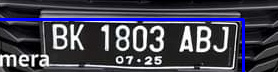

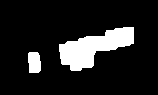

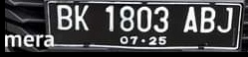

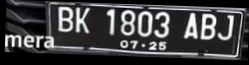

['BK', '1803', 'ABJ']



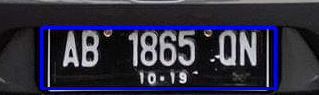

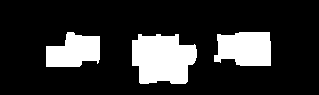

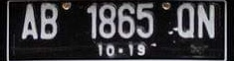

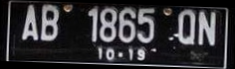

['AB', '1865', 'QN']



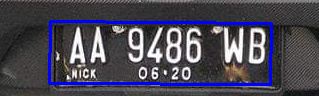

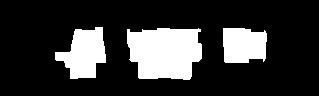

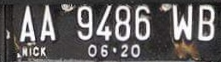

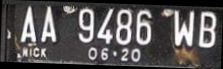

['AA', '9486', 'WB']



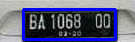

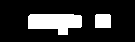

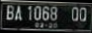

['BA', '1068', 'QQ']



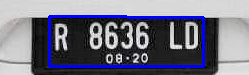

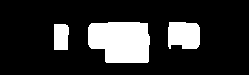

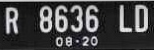

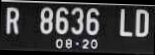

['R', '8636', 'LD']



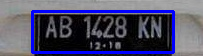

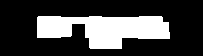

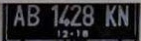

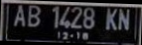

['AB', '1428', 'KN']



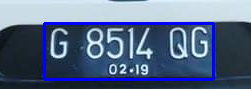

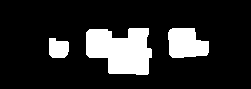

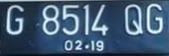

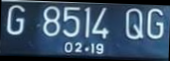

['G', '8514', 'QG']



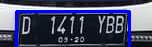

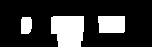

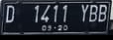

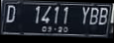

['D', '1411', 'YBB']



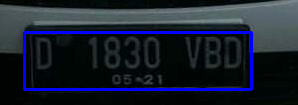

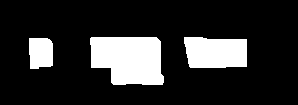

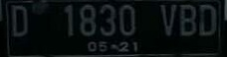

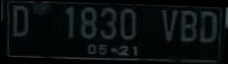

['D', '1830', 'VBD']



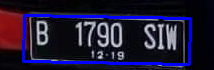

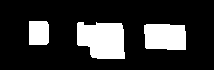

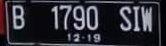

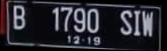

['B', '1790', 'SIW']



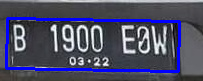

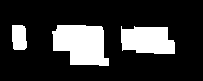

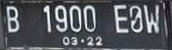

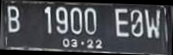

['B', '1900', 'EOW']



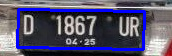

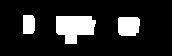

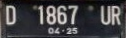

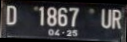

['D', '1867', 'UR']



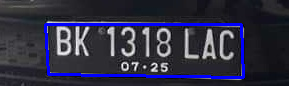

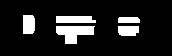

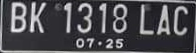

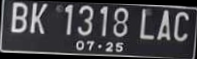

['BK', '1318', 'LAC']



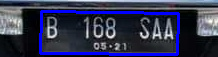

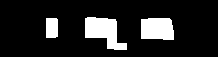

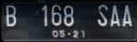

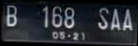

['B', '168', 'SAA']



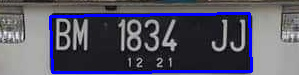

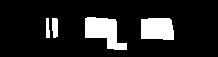

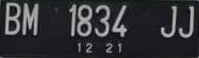

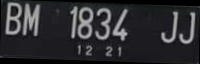

['BM', '1834', 'JJ']



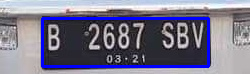

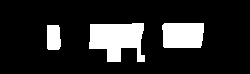

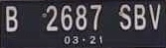

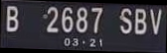

['B', '2687', 'SBV']



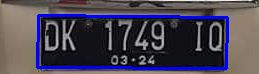

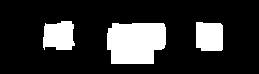

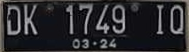

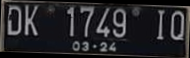

['DK', '1749', 'IQ']



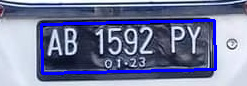

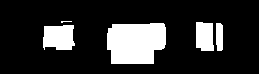

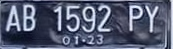

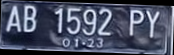

['AB', '1592', 'PY']



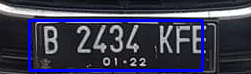

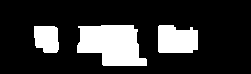

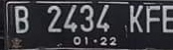

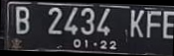

['B', '2434', 'KFE']



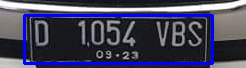

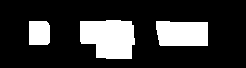

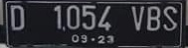

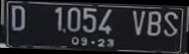

['ID', '1054', 'VBS']



In [9]:
# Menyimpan data plat nomor terbaca
plat_1 = []

# List menyimpan gambar dan nama file
images = []
filenames = []

i = 0

filenames = os.listdir(uploads_dir)

filenames.sort()

for filename in filenames :
  image = cv2.imread(os.path.join(uploads_dir, filename))

  # Mengubah ukuran gambar relatif terhadap lebar dengan menjaga aspect-ratio
  # newwidth = 300
  # image = im.resize(image, newwidth)

  # Mengubah ukuran gambar tanpa menjaga aspect-ratio
  # scale_percent = 100 # percent of original size
  # width = int(image.shape[1] * scale_percent / 100)
  # height = int(image.shape[0] * scale_percent / 100)
  # dim = (width, height)
  # image = cv2.resize(image, dim)

  # Menggunakan cara closed Contour
  NumberPlateCnt = closed_contour_method(image)

  # Jika cara closed contour tidak dapat mendeteksi
  if NumberPlateCnt.all() == 0 :
    # Menggunakan metode morphological operation
    imagen = cv2.bitwise_not(image)
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    NumberPlateCnt, thresh = locate_license_plate_candidates(imagen)

  # Proses Transformasi gambar
  ordered_points = order_points(NumberPlateCnt)
  warped_images = four_point_transform(image,ordered_points)

  # Menghitung sudut maksimum dari gambar
  degree = count_angle(ordered_points)
  epsilon = 1

  # Error Correction untuk gambar miring dengan sudut kecil
  if abs(degree) < 5 :
    rotated = im.rotate_bound(warped_images, 2)
  else :
  # Error Correction untuk gambar yang miring
    if degree <= 0 : # Jika sudut negatif (sisi kiri lebih rendah dari sisi kanan)
      rotated = im.rotate_bound(warped_images, -1*(0.1*degree) + epsilon)
    else :  # Jika sudut positif (sisi kanan lebih rendah dari sisi kiri)
      rotated = im.rotate_bound(warped_images, 0.05*degree + epsilon)
  
  # Menampilkan data hasil pembacaan Keras-OCR
  data = []
  data.append(rotated)
  temp = []

  try :
    predictions = pipeline.recognize(data)
    for imageq, prediction in zip(data, predictions) :
      for dataq in prediction :
        temp.append(dataq[0].upper())
  except :
    temp = []

  if temp == [] :
    # Menggunakan metode morphological operation
    imagen = cv2.bitwise_not(image)
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    NumberPlateCnt, tresh = locate_license_plate_candidates(imagen)
    
    # Proses Transformasi gambar
    ordered_points = order_points(NumberPlateCnt)
    warped_images = four_point_transform(image,ordered_points)

    # Menghitung sudut maksimum dari gambar
    degree = count_angle(ordered_points)
    epsilon = 1

    # Error Correction untuk gambar miring dengan sudut kecil
    if abs(degree) < 5 :
      rotated = im.rotate_bound(warped_images, 2)
    else :
    # Error Correction untuk gambar yang miring
      if degree <= 0 : # Jika sudut negatif (sisi kiri lebih rendah dari sisi kanan)
        rotated = im.rotate_bound(warped_images, -1*(0.1*degree) + epsilon)
      else :  # Jika sudut positif (sisi kanan lebih rendah dari sisi kiri)
        rotated = im.rotate_bound(warped_images, 0.05*degree + epsilon)

    # Menampilkan data hasil pembacaan Keras-OCR
    data = []
    data.append(rotated)
    temp = []

    try :
      predictions = pipeline.recognize(data)
      for imageq, prediction in zip(data, predictions) :
        for dataq in prediction :
          temp.append(dataq[0].upper())
    except :
      temp = []

  # Jika plat kendaraan amsih tidak dapat terdeteksi atau panjanganya kurang dari 3 kata
  if temp == [] or len(temp) < 3 :
    pass
  else :
    temp = temp[:3]
    while temp[0].isnumeric() or temp[1].isalpha() or temp[2].isnumeric() or i == 15 :
      # Error Correction untuk gambar yang miring
      i += 2
      rotated = im.rotate_bound(rotated, i)

      # Menampilkan data hasil pembacaan Keras-OCR
      data = [rotated]
      temp = []

      predictions = pipeline.recognize(data)
      for imageq, prediction in zip(data, predictions) :
        for dataq in prediction :
          temp.append(dataq[0].upper())

      if len(temp) < 3 :
        break
      else :
        temp = temp[:3]

  # Memasukkan data plat ke list
  list_to_string = " ".join(temp)
  plat_1.append(list_to_string)

  # Menampikan gambar dengan kontur, gambar asli, gambar hasil transofrmasi
  # dan gambar hasil error correction kemiringan
  cv2.drawContours(image, [NumberPlateCnt], -1, (255,0,0), 2)
  cv2.drawContours(thresh,[NumberPlateCnt],0,(0,0,255),2)
  cv2_imshow(image)
  cv2_imshow(thresh)
  cv2_imshow(warped_images)
  cv2_imshow(rotated)
  print(temp)
  print()

  i = 0

  
  


Kode Main() untuk sistem tanpa correction

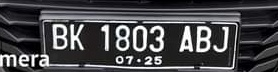

['BK', '1803', 'ABJ']



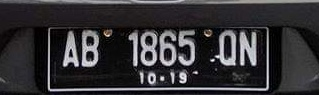

['1865', 'AB', 'QN']



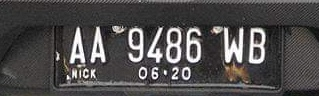

['AA', '9486', 'WB']



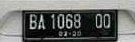

['1068', 'QQ', 'BA']



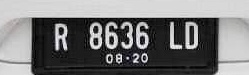

['8636', 'LD', 'R']



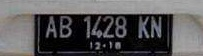

['AB', '1428', 'KN']



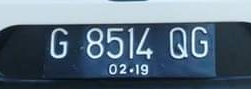

['8514', 'OG', 'G']



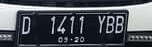

['1411', 'YBB', 'D']



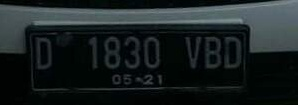

['1830', 'VBD', '96221']



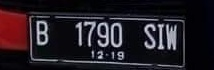

['B', '1790', 'SIW']



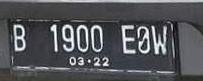

['1900', 'B', 'EOW']



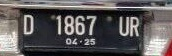

['D', '1867', 'UR']



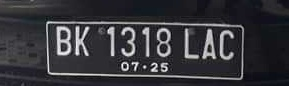

['BK', '1318', 'LAC']



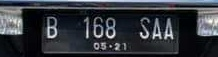

['B', '168', 'SAA']



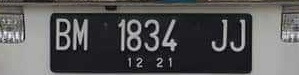

['BM', '1834', 'DJ']



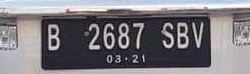

['SBV', '2687', 'B']



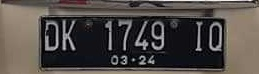

['DK', '1749', 'IQ']



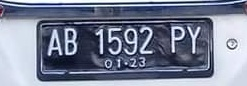

['PY', '1592', 'AB']



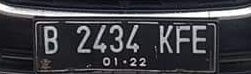

['2434', 'B', 'KFE']



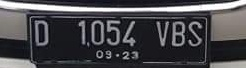

['1054', 'VBS', '922R1']



In [10]:
# List untuk menyimpan gambar
plat_2 = []

# List menyimpan gambar dan nama file
images = []
filenames = []

# Kode utama
filenames = os.listdir(uploads_dir)

filenames.sort()

for filename in filenames :
  image = cv2.imread(os.path.join(uploads_dir, filename))

  # Menampilkan data hasil pembacaan Keras-OCR
  data = [image]
  temp = []

  predictions = pipeline.recognize(data)
  for image, prediction in zip(data, predictions) :
    for data in prediction :
      temp.append(data[0].upper())

  if temp == [] :
    temp.append("Not Detected")
  
  # Menampilkan 3 kata pertama yang terdeteksi
  temp = temp[:3]
  cv2_imshow(image)
  print(temp)
  print()

  # Menyimpan hasil ke list
  list_to_string = " ".join(temp)
  plat_2.append(list_to_string)

Menyimpan data hasil OCR ke file eksternal

In [ ]:
import pandas as pd

# Menyimpan data ke file eksternal baik format .xlsx atau.csv
print(plat_1)
print(plat_2)  
dict = {'With Correction': plat_1, 'Without Correction': plat_2}  
       
df = pd.DataFrame(dict) 
    
# Menyimpan dataframe ke file eksternal
# df.to_csv('/content/drive/MyDrive/KP/Masters.csv')
df.to_excel(r'/content/drive/MyDrive/KP/Masters_test_hard_skewed.xlsx', index = False)

['L 1409 KZ', 'N 1098 P', 'B 2664 BFO', 'N 1327 DD', 'W 1493 CE', 'KRS 1302 B', 'BKQ 7522 AN', 'DB 186 LD', 'H 8442 SZ', 'D 1504 VBS', 'H 9189 HW', 'B 2012 SYR', 'B 2558 SOB', 'AB 1208 EJ', 'AB NW5S NNS', 'P 9373 EK', 'BP 7369 UPL', 'B 22484 TKY', 'H 8679 QZ', 'D 1348 AGR']
['1409 KZ 122', 'CP 1098 N', 'BFO 264 DO', 'OD 127 O', '1493 CE N9OA', 'BG 13102 5', 'KH 1522 BN', 'DB 186 LD', '8442 SZ 9221', 'VBS 1504 23', '9189 TW 92', 'SYR 212 B', 'SQB 2558 B', 'AB 1208 EJ', 'AB N5S Y', 'EK 9379 R', 'UIL 7369 B', 'TKN 2248 B', 'H 8679 QZ', 'AGRO 1348 D']
